#This Ml project helps to predict possible insurance money of a person



Note: this algorithm is trained on the insurance.csv attached to it

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import warnings


warnings.filterwarnings("ignore")

In [122]:
df= pd.read_csv('insurance.csv')
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


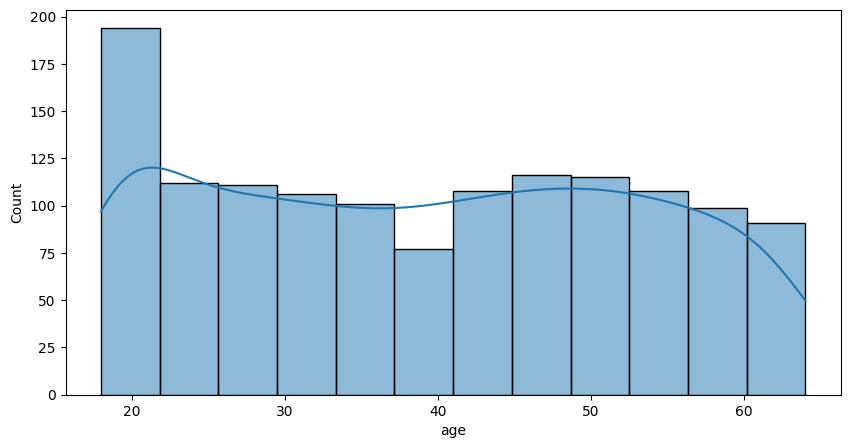

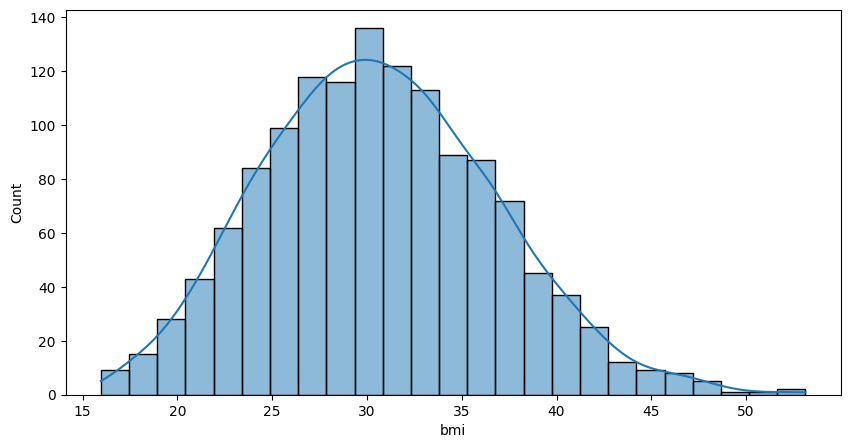

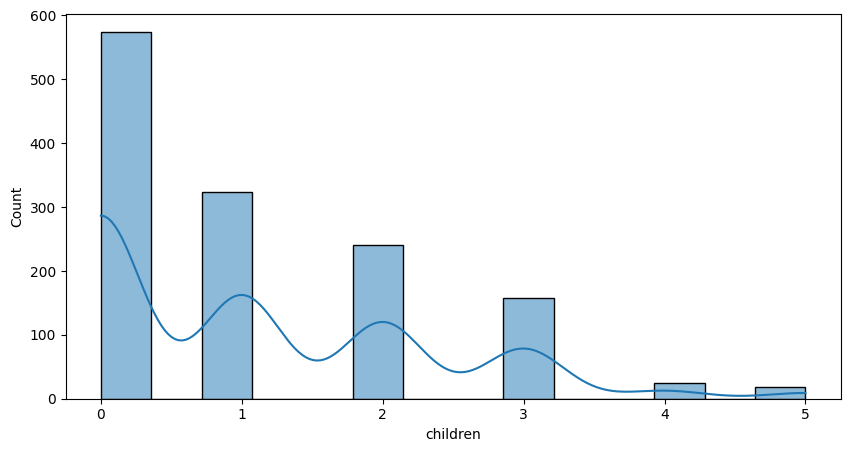

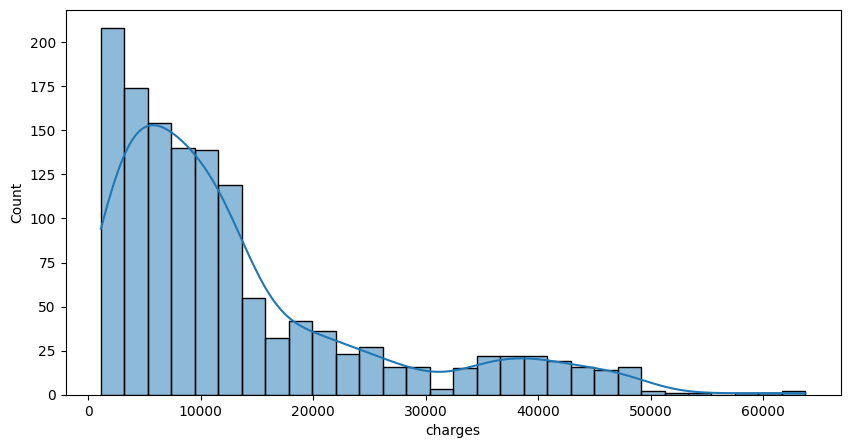

In [123]:
df.shape
df.columns
numeric_columns= ['age', 'bmi', 'children', 'charges']
for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True)


<Axes: >

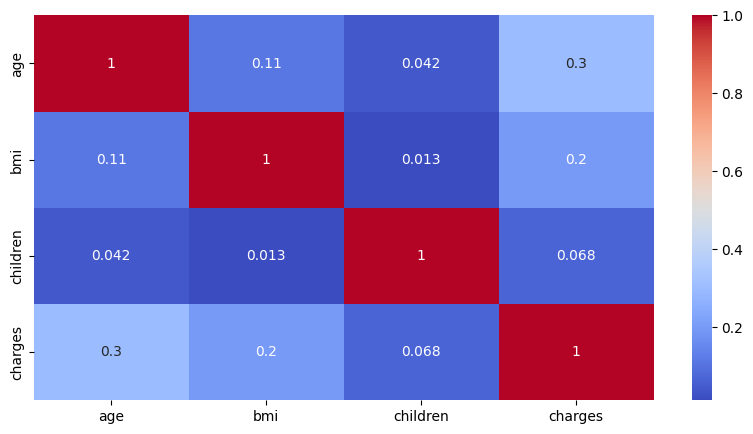

In [124]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(numeric_only= True), annot=True, cmap='coolwarm')

Data cleaning

In [125]:
df_clinned = df.copy()
df_clinned.drop_duplicates(inplace=True)

In [126]:
df_clinned['sex'].value_counts()
df_clinned['sex']= df_clinned['sex'].map({'male': 0, 'female': 1})

In [127]:
df_clinned['smoker'].value_counts()
df_clinned['smoker']= df_clinned['smoker'].map({'no': 0, 'yes': 1})

In [128]:
df_clinned= pd.get_dummies(df_clinned, columns=['region'], drop_first=True)
df_clinned.head

<bound method NDFrame.head of       age  sex     bmi  children  smoker      charges  region_northwest  \
0      19    1  27.900         0       1  16884.92400             False   
1      18    0  33.770         1       0   1725.55230             False   
2      28    0  33.000         3       0   4449.46200             False   
3      33    0  22.705         0       0  21984.47061              True   
4      32    0  28.880         0       0   3866.85520              True   
...   ...  ...     ...       ...     ...          ...               ...   
1333   50    0  30.970         3       0  10600.54830              True   
1334   18    1  31.920         0       0   2205.98080             False   
1335   18    1  36.850         0       0   1629.83350             False   
1336   21    1  25.800         0       0   2007.94500             False   
1337   61    1  29.070         0       1  29141.36030              True   

      region_southeast  region_southwest  
0                False    

In [129]:
df_clinned= df_clinned.astype(int)
print(df_clinned)

      age  sex  bmi  children  smoker  charges  region_northwest  \
0      19    1   27         0       1    16884                 0   
1      18    0   33         1       0     1725                 0   
2      28    0   33         3       0     4449                 0   
3      33    0   22         0       0    21984                 1   
4      32    0   28         0       0     3866                 1   
...   ...  ...  ...       ...     ...      ...               ...   
1333   50    0   30         3       0    10600                 1   
1334   18    1   31         0       0     2205                 0   
1335   18    1   36         0       0     1629                 0   
1336   21    1   25         0       0     2007                 0   
1337   61    1   29         0       1    29141                 1   

      region_southeast  region_southwest  
0                    0                 1  
1                    1                 0  
2                    1                 0  
3          

Feature Engineering

In [130]:
df_clinned['bmi_type'] = pd.cut(df_clinned['bmi'], bins=[0, 18.5, 24.9, 29.9, np.inf], labels=['underweight', 'normal', 'overweight', 'obese'])

In [131]:
df_clinned= pd.get_dummies(df_clinned, columns=['bmi_type'], drop_first=True)
df_clinned = df_clinned.astype(int)

In [132]:
from sklearn.preprocessing import StandardScaler
cols = ['age', 'bmi', 'children', 'charges']
scalar = StandardScaler()
df_clinned[cols] = scalar.fit_transform(df_clinned[cols])


In [133]:
from scipy.stats import pearsonr
#pearson correlation calculation
selected_features= ['age','bmi','children','charges','sex', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest','bmi_type_normal', 'bmi_type_overweight', 'bmi_type_obese']
corelations = {feature: pearsonr(df_clinned[feature], df_clinned['charges'])[0] for feature in selected_features}
corelations_df = pd.DataFrame(list(corelations.items()), columns=['Feature', 'Correlation'])
corelations_df= corelations_df.sort_values(by='Correlation', ascending=False)
print(corelations_df)

                Feature  Correlation
3               charges     1.000000
5                smoker     0.787234
0                   age     0.298309
11       bmi_type_obese     0.200348
1                   bmi     0.196236
7      region_southeast     0.073577
2              children     0.067390
6      region_northwest    -0.038695
8      region_southwest    -0.043637
4                   sex    -0.058046
9       bmi_type_normal    -0.104042
10  bmi_type_overweight    -0.120601


In [134]:
cat_features= ['sex', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest','bmi_type_normal', 'bmi_type_overweight', 'bmi_type_obese']


In [135]:
from scipy.stats import chi2_contingency
alpha = 0.05
df_clinned['charges'] = pd.qcut(df_clinned['charges'], q=4, labels=False)
chi2_contingency_results = {}


for feature in cat_features:
    contingency_table = pd.crosstab(df_clinned[feature], df_clinned['charges'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    descision = 'Reject null(keep feature)' if p < alpha else 'Accept null(drop feature)'
    chi2_contingency_results[feature] = {
        'Chi2': chi2,
        'p-value': p,
        'Decision': descision
    }
chi2_df = pd.DataFrame(chi2_contingency_results).T
print(chi2_df.sort_values(by='p-value', ascending=True))

                           Chi2   p-value                   Decision
smoker               848.219178       0.0  Reject null(keep feature)
region_southeast      15.998167  0.001135  Reject null(keep feature)
sex                   10.258784   0.01649  Reject null(keep feature)
bmi_type_obese         8.515711  0.036473  Reject null(keep feature)
region_southwest       5.091893  0.165191  Accept null(drop feature)
bmi_type_overweight     4.25149  0.235557  Accept null(drop feature)
bmi_type_normal        3.708088   0.29476  Accept null(drop feature)
region_northwest        1.13424  0.768815  Accept null(drop feature)


In [136]:
final_df= df_clinned[['age', 'bmi', 'children', 'charges','smoker']]
print(final_df)

           age       bmi  children  charges  smoker
0    -1.440418 -0.517949 -0.909234        3       1
1    -1.511647  0.462463 -0.079442        0       0
2    -0.799350  0.462463  1.580143        0       0
3    -0.443201 -1.334960 -0.909234        3       0
4    -0.514431 -0.354547 -0.909234        0       0
...        ...       ...       ...      ...     ...
1333  0.767704 -0.027743  1.580143        2       0
1334 -1.511647  0.135659 -0.909234        0       0
1335 -1.511647  0.952670 -0.909234        0       0
1336 -1.297958 -0.844753 -0.909234        0       0
1337  1.551231 -0.191145 -0.909234        3       1

[1337 rows x 5 columns]


Under work............